In [1]:
import matplotlib.pyplot as plt
import numpy as np
from brian2.only import *
import seaborn as sns
import deepdish as dd
import scipy.stats as stats
from matplotlib.collections import LineCollection

import plot_utils as pu
from digest import conds, get_digest_output, get_voltages, get_voltage_histograms
import isi_indexing as ii
from readout import load_results
import spatial

import conf.isi5_mouse as cfg
from demonstrator import demonstrator

import styling

In [2]:
labelling = {
    'nspikes': 'Response size',
    'pspike': 'Spike probability',
    'Activity': '$V_{static}$ (mV)',
    'Depression': '$V_{STD}$ (mV)',
    'Threshold': '$V_{TA}$ (mV)',
    'Synapses': '$V_{syn}$ (mV)',
    'Reset': '$V_{reset}$ (mV)',
    'v': 'Membrane potential v (mV)',
    'u': 'Undepressed potential u (mV)',
    'th_adapt': 'Threshold (mV)',
    'vsyn': '$v_{syn}$',
    'Vall': '$\\Sigma V$ (mV)'
}
depressive_measures = ('Depression', 'Threshold')
voltage_measures = depressive_measures + ('Synapses', 'Reset')
raw_measures = 'th_adapt', 'u', 'v', 'vsyn'
pu.colors.update({'Activity': 'cyan', 'Vall': 'k',
                  'th_adapt': pu.colors['Threshold'], 'u': pu.colors['Depression'], 'v': 'b', 'vsyn':'magenta'})
conds = ('std', 'msc', 'dev')
nonstandard = ('msc', 'dev')

In [3]:
net, ipair, istim = [demonstrator[k] for k in ('net', 'ipair', 'istim')]
pair, stim, Bstim = cfg.pairings[ipair], cfg.pairings[ipair][istim], cfg.pairings[ipair][1-istim]

In [4]:
netf = dd.io.load(cfg.netfile.format(net=net))
X, Y = netf['X']/cfg.params['r_dish'].item(), netf['Y']/cfg.params['r_dish'].item()
W = netf['W']
Xstim, Ystim = spatial.create_stimulus_locations(cfg.params)
Xstim = Xstim / cfg.params['r_dish']
Ystim = Ystim / cfg.params['r_dish']

In [5]:
def scatter_values(ax, **kwargs):
    m = ax.scatter(X, Y, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(-1.1,1.1)
    ax.set_ylim(-1.1,1.1)
    sns.despine(ax=ax, left=True, bottom=True)
    ax.set_aspect('equal')
    return m

In [6]:
ms = 20

In [7]:
early = 100

In [8]:
def get_bspikes(res, episode):
    b = np.zeros(np.asarray(res['raw_dynamics']['v'].shape)[[0,2,3]], bool)
    for itrial, (i, spike_t) in enumerate(zip(*[res['raw_spikes'][episode][f'pulsed_{k}'] for k in 'it'])):
        t = (spike_t / cfg.params['dt'] + .5).astype(int)
        b[i, itrial, t] = True
    return b

In [9]:
class Results:
    def __init__(self, net, isi, STD, TA, templ, *args, **kwargs):
        self.res = res = load_results(cfg.fname.format(net=net, isi=isi, STD=STD, TA=TA, templ=templ), *args, **kwargs)
        
        self.episodes = episodes = {cond: res['pairs'][ipair][cond][stim] for cond in conds}
        self.sequences = sequences = {cond: res['sequences'][episode] for cond, episode in episodes.items()}
        self.trials = trials = {cond: seq == cfg.stimuli[stim] for cond, seq in sequences.items()}
        trials.update({f'{cond}-nontarget': seq != cfg.stimuli[stim] for cond, seq in sequences.items()})
        trials.update({f'{cond}-B': seq == cfg.stimuli[cfg.pairings[ipair][1-istim]] for cond, seq in sequences.items()})

        self.bspikes = {cond: get_bspikes(res, ep) for cond, ep in episodes.items()}

        self.TA_A_dev = res['raw_dynamics']['th_adapt'][:, episodes['dev'], trials[f'dev'], 0].mean(1)*volt/mV
        self.TA_A_msc = res['raw_dynamics']['th_adapt'][:, episodes['msc'], trials[f'msc'], 0].mean(1)*volt/mV
        self.dTA_A = self.TA_A_dev - self.TA_A_msc
        
        self.XA_dev = self.bspikes['dev'][:, trials['dev']].sum(2).mean(1)
        self.XA_msc = self.bspikes['msc'][:, trials['msc']].sum(2).mean(1)
        self.dXA = self.XA_dev - self.XA_msc
        
        self.TA_B_dev = self.TA_notA_dev = res['raw_dynamics']['th_adapt'][:, episodes['dev'], trials[f'dev-B'], 0].mean(1)*volt/mV
        self.TA_B_msc = res['raw_dynamics']['th_adapt'][:, episodes['msc'], trials[f'msc-B'], 0].mean(1)*volt/mV
        self.TA_notA_msc = res['raw_dynamics']['th_adapt'][:, episodes['msc'], ~(trials['msc']|trials['msc-B']), 0].mean(1)*volt/mV
        self.dTA_B = self.TA_B_dev - self.TA_B_msc
        self.dTA_notA = self.TA_notA_dev - self.TA_notA_msc
        
        self.XB_dev = self.XnotA_dev = self.bspikes['dev'][:, trials['dev-B']].sum(2).mean(1)
        self.XB_msc = self.bspikes['msc'][:, trials['msc-B']].sum(2).mean(1)
        self.XnotA_msc = self.bspikes['msc'][:, ~trials['msc']].sum(2).mean(1)
        self.XnotAB_msc = self.bspikes['msc'][:, ~(trials['msc']|trials['msc-B'])].sum(2).mean(1)
        self.dXnotA = self.XnotA_dev - self.XnotA_msc
        
        self.dXB_adaptation = self.XB_dev - self.XB_msc
        self.dXB_stimchange = self.XB_msc - self.XnotA_msc

        index_N, index_t = ii.get_onset_ordering(cfg, np.stack([b[:, trials[f'{cond}-B'], :].mean(1) for cond, b in self.bspikes.items()]))
        self.index_B, self.early, self.late = index_N[:, 0], index_N[:early, 0], index_N[early:, 0]

In [10]:
isi, STD, TA, templ = 500, 0, 1, 'R'
half = Results(net, isi, 0, TA, templ, dynamics_supplements={'u': 'v'})
joint = Results(net, isi, 1, TA, templ, dynamics_supplements={'u': 'v'})
statistics = dd.io.load('Fig6-stats.h5')

In [11]:
def spatial_contrast(axs_raw, cax_raw, ax_contrast, cax_contrast, dev, msc, diff, ms=1, raw_symmetric=False, raw_also=[], contrast_also=[]):
    vmax = np.abs([dev, msc] + raw_also).max()
    vmin = -vmax if raw_symmetric else 0
    cmap_raw = pu.ccc_divergent if raw_symmetric else 'turbo'
    m = scatter_values(axs_raw[0], c=dev, s=ms, vmin=vmin, vmax=vmax, cmap=cmap_raw)
    m = scatter_values(axs_raw[1], c=msc, s=ms, vmin=vmin, vmax=vmax, cmap=cmap_raw)
    plt.colorbar(m, cax=cax_raw)

    if ax_contrast is None:
        return

    vmax = np.abs([diff] + contrast_also).max()
    m = scatter_values(ax_contrast, c=diff, s=ms, vmin=-vmax, vmax=vmax, cmap=pu.ccc_divergent)
    plt.colorbar(m, cax=cax_contrast)

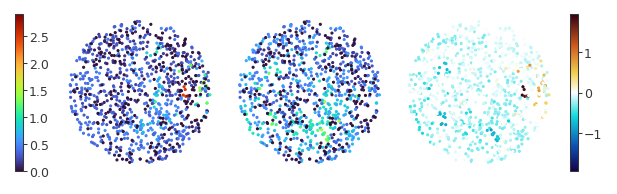

In [12]:
fig, axs = plt.subplots(1, 5, figsize=(4, 2), gridspec_kw={'width_ratios': (.1,2,2,2,.1)}, dpi=150, layout='compressed')
spatial_contrast(axs[1:3], axs[0], axs[3], axs[4], half.TA_A_dev, half.TA_A_msc, half.dTA_A)

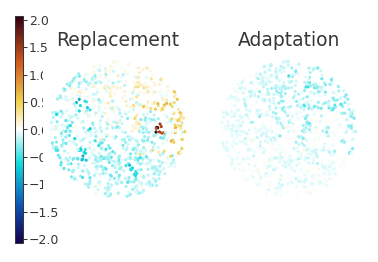

In [13]:
def panel_nontarget_causes_spatial(axs, cax, stimchange, adaptation, ms=1):
    vmax = max(*[np.abs(val).max() for val in (adaptation, stimchange)])
    scatter_values(axs[0], c=stimchange, s=ms, vmin=-vmax, vmax=vmax, cmap=pu.ccc_divergent)
    axs[0].set_title('Replacement')
    m = scatter_values(axs[1], c=adaptation, s=ms, vmin=-vmax, vmax=vmax, cmap=pu.ccc_divergent)
    axs[1].set_title('Adaptation')
    plt.colorbar(m, cax=cax)
    for ax in axs:
        ax.set_aspect('equal')

fig, axs = plt.subplots(1, 3, figsize=(3, 2), gridspec_kw={'width_ratios': (.1, 2, 2)}, dpi=150)
panel_nontarget_causes_spatial(axs[1:], axs[0], half.dXB_stimchange, half.dXB_adaptation)

Replacement != 0: t = -0.255, p = 0.799
Adaptation < 0: t = -9.01, p = 2.02e-15
Adaptation < Replacement: t = -2.86, p = 0.00248


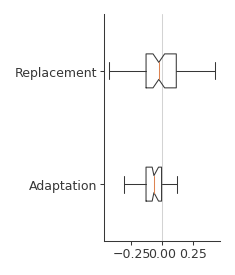

In [14]:
def panel_nontarget_causes_stats(ax, stimchange, adaptation, vert=False):
    if vert:
        ax.axhline(0, color='lightgrey', zorder=0)
    else:
        ax.axvline(0, color='lightgrey', zorder=0)
    ax.boxplot([change.mean(1) for change in (stimchange, adaptation)], notch=True, bootstrap=10000,
               labels=['Replacement', 'Adaptation'], widths=.3, vert=vert, positions=(1-vert,vert))
    # ax.set_ylabel('$\\Delta$ spikes per trial and neuron')
    sns.despine(ax=ax)
    
    test = stats.ttest_1samp(stimchange.mean(1), 0, alternative='two-sided')
    print(f'Replacement != 0: t = {test.statistic:.3g}, p = {test.pvalue:.3g}')
    test = stats.ttest_1samp(adaptation.mean(1), 0, alternative='less')
    print(f'Adaptation < 0: t = {test.statistic:.3g}, p = {test.pvalue:.3g}')
    test = stats.ttest_rel(adaptation.mean(1), stimchange.mean(1), alternative='less')
    print(f'Adaptation < Replacement: t = {test.statistic:.3g}, p = {test.pvalue:.3g}')
fig, ax = plt.subplots(figsize=(1,2), dpi=150)
panel_nontarget_causes_stats(ax, *[statistics[k][0][1] for k in ('stimchange', 'adaptation')])

notA spikes vs A TA (demonstrator): r = 0.99, p = 0


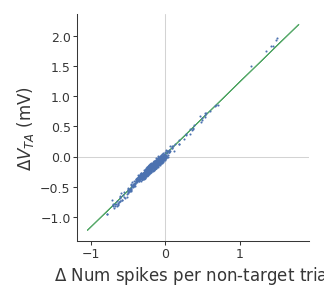

In [15]:
def panel_TAvSpikes(ax, data, ms=1, xlabel='Num spikes per non-target trial'):
    ax.scatter(data.dXnotA[:cfg.params['N_exc']], data.dTA_A[:cfg.params['N_exc']], s=ms, marker='.', c='b', label='Excitatory', zorder=2)
    regression = stats.linregress(data.dXnotA[:cfg.params['N_exc']], data.dTA_A[:cfg.params['N_exc']])
    ax.plot(data.dXnotA, regression.intercept + regression.slope*data.dXnotA, 'C2', label=f'r={regression.rvalue:.3g}, p={regression.pvalue:.2g}', zorder=1)

    ax.axvline(0, color='lightgrey', zorder=0)
    ax.axhline(0, color='lightgrey', zorder=0)
    ax.set_xlabel(f'$\\Delta$ {xlabel}')
    ax.set_ylabel('$\\Delta V_{TA}$ (mV)')
    sns.despine(ax=ax)

    print(f'notA spikes vs A TA (demonstrator): r = {regression.rvalue:.3g}, p = {regression.pvalue:.3g}')
fig, ax = plt.subplots(figsize=(2,2), dpi=150)
panel_TAvSpikes(ax, half)

rho > 0: t = 2.1e+03, p = 4.47e-274, median = 0.990
dXnotA < 0: t = -8, p = 4.65e-13, median = -0.075


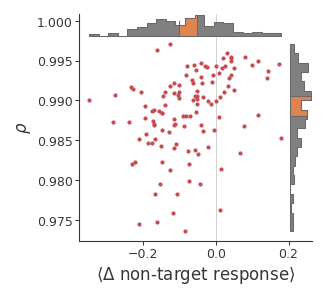

In [25]:
def panel_TAvSpikes_stats(ax, STD, ms=2, xlabel='non-target response'):
    r, s = [], []
    for dx, dth in zip(statistics['dXnotA'][STD][1], statistics['dTA_A'][STD]):
        regression = stats.linregress(
            dx[:cfg.params['N_exc']],
            dth[:cfg.params['N_exc']],
            alternative='greater')
        plt.plot(np.mean(dx[:cfg.params['N_exc']]), regression.rvalue, '.', ms=ms, c='r' if regression.pvalue < .05 else styling.offblack, zorder=1)
        r.append(regression.rvalue)
        s.append(np.mean(dx[:cfg.params['N_exc']]))
    pu.inset_hist(ax, r, False)
    pu.inset_hist(ax, s, True)
    
    ax.set_xlabel(f'$\\langle \\Delta$ {xlabel}$\\rangle$')
    ax.set_ylabel('$\\rho$')
    ax.axhline(0, color='lightgrey', zorder=0)
    ax.axvline(0, color='lightgrey', zorder=0)
    sns.despine(ax=ax)
    
    test = stats.ttest_1samp(r, 0, alternative='greater')
    print(f'rho > 0: t = {test.statistic:.3g}, p = {test.pvalue:.3g}, median = {np.median(r):.3f}')
    test = stats.ttest_1samp(s, 0, alternative='less')
    print(f'dXnotA < 0: t = {test.statistic:.3g}, p = {test.pvalue:.3g}, median = {np.median(s):.3f}')

fig, ax = plt.subplots(figsize=(2, 2), dpi=150)
panel_TAvSpikes_stats(ax, 0)

dR (early) > 0: t = 14.4, p = 3.56e-28
dTA (early) > 0: t = 11.6, p = 1.27e-21
early dR vs dTA: $\rho$ = 0.894, p = 3.67e-43


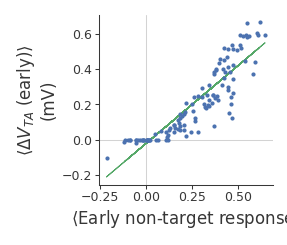

In [17]:
def panel_early_correlation(ax, dR_early, dTA_early, ms=2):
    ax.plot(dR_early, dTA_early, '.', ms=ms, zorder=2)
    reg = stats.linregress(dR_early, dTA_early, alternative='greater')
    ax.plot(dR_early, dR_early*reg.slope + reg.intercept, c='C2', zorder=1)

    ax.axvline(0, color='lightgrey', zorder=0)
    ax.axhline(0, color='lightgrey', zorder=0)
    ax.set_xlabel('$\\langle$Early non-target response$\\rangle$')
    ax.set_ylabel('$\\langle\\Delta V_{TA}$ (early)$\\rangle$\n(mV)')
    sns.despine(ax=ax)
    
    test = stats.ttest_1samp(dR_early, 0, alternative='greater')
    print(f'dR (early) > 0: t = {test.statistic:.3g}, p = {test.pvalue:.3g}')
    test = stats.ttest_1samp(dTA_early, 0, alternative='greater')
    print(f'dTA (early) > 0: t = {test.statistic:.3g}, p = {test.pvalue:.3g}')

    print(f'early dR vs dTA: $\\rho$ = {reg.rvalue:.3g}, p = {reg.pvalue:.3g}')

fig, ax = plt.subplots(figsize=(1.5,1.5), dpi=150)
panel_early_correlation(ax, statistics['dXnotA_early'][0][1], statistics['dTA_B_early'][0])

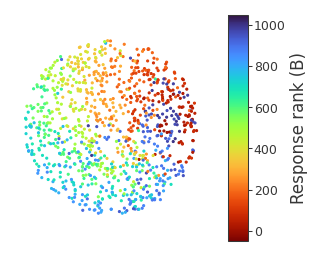

In [27]:
cbar_overflow = .05
def panel_RB_latency(ax, cax, data, ms=1):
    m = scatter_values(ax, c=np.argsort(data.index_B), cmap='turbo_r', s=ms, vmin=-cbar_overflow*cfg.params['N'], vmax=(1+cbar_overflow)*cfg.params['N'])
    plt.colorbar(m, cax=cax, label='Response rank (B)')

fig, axs = plt.subplots(1, 2, figsize=(2,2), dpi=150, width_ratios=(10,1))
panel_RB_latency(*axs, joint)

Sample rho = 0.978 > 0: p = 0


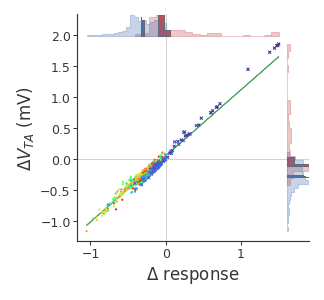

In [19]:
def panel_early_sample(ax, data):
    rank = np.argsort(data.index_B)[:cfg.params['N_exc']]
    mask = rank<early
    dX = data.dXnotA[:cfg.params['N_exc']]
    dTA = data.dTA_notA[:cfg.params['N_exc']]

    ax.scatter(dX[~mask], dTA[~mask], c=rank[~mask], marker='.', s=1, cmap='turbo',
        vmin=-cbar_overflow*cfg.params['N'], vmax=(1+cbar_overflow)*cfg.params['N'], zorder=2)
    ax.scatter(dX[mask], dTA[mask], c=rank[mask], marker='x', s=2, cmap='turbo',
        vmin=-cbar_overflow*cfg.params['N'], vmax=(1+cbar_overflow)*cfg.params['N'], zorder=2)
    reg = stats.linregress(dX, dTA, alternative='greater')
    ax.plot(dX, reg.slope*dX + reg.intercept, c='C2', zorder=1)

    pu.inset_hist(ax, dX[mask], median_color='r', color='r', alpha=.3, edgecolor='r')
    pu.inset_hist(ax, dX[~mask], median_color='b', color='b', alpha=.3, edgecolor='b', rescale=False)
    pu.inset_hist(ax, dTA[mask], x=False, median_color='r', color='r', alpha=.3, edgecolor='r')
    pu.inset_hist(ax, dTA[~mask], x=False, median_color='b', color='b', alpha=.3, edgecolor='b', rescale=False)

    ax.axvline(0, color='lightgrey', zorder=0)
    ax.axhline(0, color='lightgrey', zorder=0)
    ax.set_xlabel('$\\Delta$ response')
    ax.set_ylabel('$\\Delta V_{TA}$ (mV)')
    sns.despine(ax=ax)

    print(f'Sample rho = {reg.rvalue:.3g} > 0: p = {reg.pvalue:.3g}')

fig, ax = plt.subplots(figsize=(2,2), dpi=150)
panel_early_sample(ax, joint)

dXnotA ~ dTA_B, rho > 0: T = 7.26e+03, p = 9.86e-22, median = 0.992
early dXnotA > 0: T = 6.98e+03, p = 8.48e-19
late dXnotA < 0: T = 295, p = 1.23e-18
all dXnotA < 0: T = 1.07e+03, p = 1.01e-11
early dTA_B > 0: T = 4.63e+03, p = 2.21e-17
late dTA_B < 0: T = 26, p = 2.97e-17
all dTA_B < 0: T = 1.28e+03, p = 4.09e-10


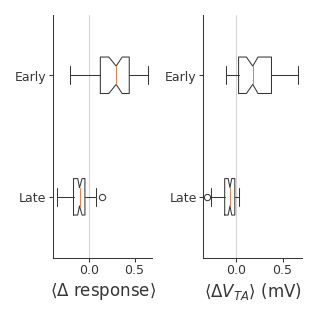

In [20]:
def panel_early_stats(axs, STD, vert=False):
    def plot(ax, early, late, label):
        ax.boxplot(
            [early, late], labels=['Early', 'Late'], widths=.3, zorder=1,
            vert=vert, notch=True, bootstrap=10000, positions=(1-vert,vert))
        if vert:
            ax.set_ylabel(label)
            ax.axhline(0, color='lightgrey', zorder=0)
        else:
            ax.set_xlabel(label)
            ax.axvline(0, color='lightgrey', zorder=0)
        sns.despine(ax=ax)

    plot(axs[0], statistics['dXnotA_early'][STD][1], statistics['dXnotA_late'][STD][1],
        '$\\langle \\Delta$ response$\\rangle$')
    plot(axs[1], statistics['dTA_B_early'][STD], statistics['dTA_B_late'][STD],
        '$\\langle \\Delta V_{TA}\\rangle$ (mV)')

    r = []
    for dx, dth in zip(statistics['dXnotA'][STD][1], statistics['dTA_B'][STD]):
        regression = stats.linregress(
            dx[:cfg.params['N_exc']],
            dth[:cfg.params['N_exc']],
            alternative='greater')
        r.append(regression.rvalue)
    test = stats.wilcoxon(r, alternative='greater')
    print(f'dXnotA ~ dTA_B, rho > 0: T = {test.statistic:.3g}, p = {test.pvalue:.3g}, median = {np.median(r):.3f}')

    test = stats.wilcoxon(statistics['dXnotA_early'][STD][1], alternative='greater')
    print(f'early dXnotA > 0: T = {test.statistic:.3g}, p = {test.pvalue:.3g}')
    test = stats.wilcoxon(statistics['dXnotA_late'][STD][1], alternative='less')
    print(f'late dXnotA < 0: T = {test.statistic:.3g}, p = {test.pvalue:.3g}')
    test = stats.wilcoxon(statistics['dXnotA'][STD][1].mean(1), alternative='less')
    print(f'all dXnotA < 0: T = {test.statistic:.3g}, p = {test.pvalue:.3g}')

    test = stats.wilcoxon(statistics['dTA_B_early'][STD], alternative='greater')
    print(f'early dTA_B > 0: T = {test.statistic:.3g}, p = {test.pvalue:.3g}')

    test = stats.wilcoxon(statistics['dTA_B_late'][STD], alternative='less')
    print(f'late dTA_B < 0: T = {test.statistic:.3g}, p = {test.pvalue:.3g}')
    test = stats.wilcoxon(statistics['dTA_B'][STD].mean(1), alternative='less')
    print(f'all dTA_B < 0: T = {test.statistic:.3g}, p = {test.pvalue:.3g}')

fig, axs = plt.subplots(1,2, figsize=(2,2), dpi=150, layout='constrained')
panel_early_stats(axs, 0)

In [21]:
def draw_stim_loc(ax):
    for s, AB in zip((stim, Bstim), 'AB'):
        x, y = [c[joint.res['stimuli'][s]] for c in (Xstim, Ystim)]
        r = .2
        o = 1/np.sqrt(x**2+y**2)
        lpoints = np.asarray([1+r, .1+o])
        ax.add_patch(plt.Circle((x, y), r, fc='none', ec='magenta'))
        ax.plot(lpoints*x, lpoints*y, 'magenta', clip_on=False)
        ax.text(lpoints[-1]*x, lpoints[-1]*y, AB, ha='left' if x>=0 else 'right', va='bottom' if y>=0 else 'top')

No STD:
notA spikes vs A TA (demonstrator): r = 0.99, p = 0
rho > 0: t = 1.7e+03, p = 5.13e-263, median = 0.989
dXnotA < 0: t = -9.76, p = 3.5e-17, median = -0.106

With STD:
notA spikes vs A TA (demonstrator): r = 0.985, p = 0
rho > 0: t = 1.7e+03, p = 5.13e-263, median = 0.989
dXnotA < 0: t = -9.76, p = 3.5e-17, median = -0.106


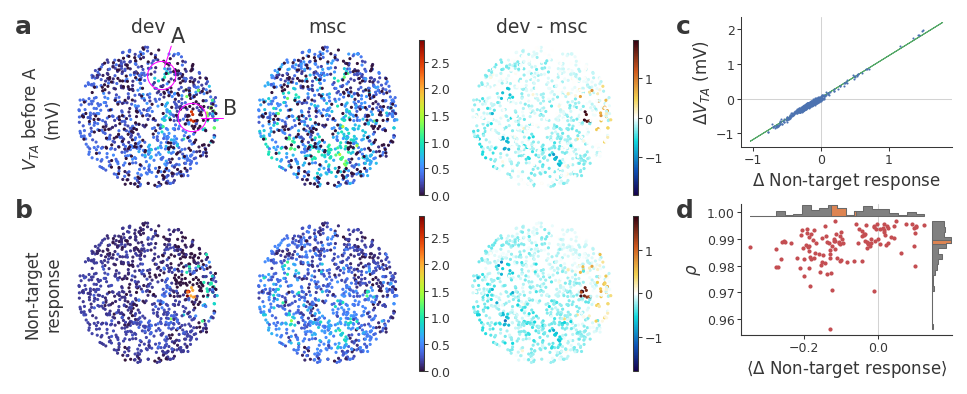

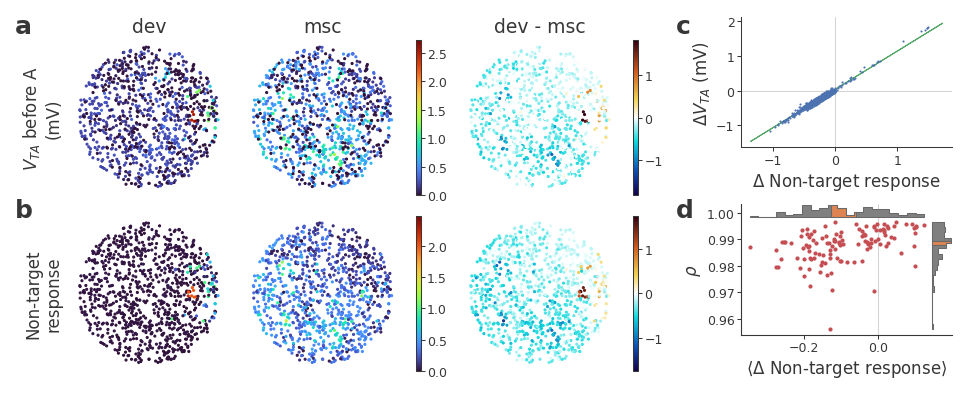

In [22]:
def make_figure_5(data, STD, with_loc=True):
    fig = plt.figure(figsize=(6.29, 2.5), dpi=150, layout='compressed')
    gs_top = fig.add_gridspec(1, 2, width_ratios=(7,3))

    subfig_left = fig.add_subfigure(gs_top[0])
    wr = pu.fill_ratios(-1, -1, 1, -1, 1)
    gs_left = subfig_left.add_gridspec(2, 5, width_ratios=wr)

    nspk_label = 'Non-target\nresponse'

    for row, (measure, title) in enumerate((('TA_A', '$V_{TA}$ before A\n(mV)'),
                                            ('XnotA', nspk_label))):
        cax_raw = subfig_left.add_subplot(gs_left[row, 2])
        axs_raw = [subfig_left.add_subplot(gs_left[row, i]) for i in range(2)]
        ax_diff = subfig_left.add_subplot(gs_left[row, 3])
        cax_diff = subfig_left.add_subplot(gs_left[row, 4])
        spatial_contrast(axs_raw, cax_raw, ax_diff, cax_diff, *[getattr(data, f'{measure}_{cond}') for cond in ('dev', 'msc')], getattr(data, f'd{measure}'))
        if row == 0:
            axs_raw[0].set_title('dev')
            axs_raw[1].set_title('msc')
            ax_diff.set_title('dev - msc')
            if with_loc:
                draw_stim_loc(axs_raw[0])
        axs_raw[0].set_ylabel(title)

    subfig_right = fig.add_subfigure(gs_top[1])
    gs_summaries = subfig_right.add_gridspec(2,1)

    ax = subfig_right.add_subplot(gs_summaries[0])
    panel_TAvSpikes(ax, data, xlabel=nspk_label.replace('\n', ' '))

    ax = subfig_right.add_subplot(gs_summaries[1])
    panel_TAvSpikes_stats(ax, 1, xlabel=nspk_label.replace('\n', ' '))

    for y, a in zip((.99, .5), 'ab'):
        fig.text(0, y, a, **styling.label_kwargs, ha='left', va='top')
    for y, a in zip((.99, .5), 'cd'):
        fig.text(.7, y, a, **styling.label_kwargs, ha='left', va='top')

print('No STD:')
make_figure_5(half, 0)
plt.savefig('paper-1/fig5.pdf')

print('\nWith STD:')
make_figure_5(joint, 1, with_loc=False)
plt.savefig('paper-1/fig5-withSTD.pdf')

WARNING    /home/felix/projects/culture/plot_utils.py:113: RuntimeWarning: divide by zero encountered in long_scalars
  ratios[ratios<0] = remainder / (ratios<0).sum()
 [py.warnings]


No STD:
Sample rho = 0.993 > 0: p = 0
dXnotA ~ dTA_B, rho > 0: T = 7.26e+03, p = 9.86e-22, median = 0.992
early dXnotA > 0: T = 6.98e+03, p = 8.48e-19
late dXnotA < 0: T = 295, p = 1.23e-18
all dXnotA < 0: T = 1.07e+03, p = 1.01e-11
early dTA_B > 0: T = 4.63e+03, p = 2.21e-17
late dTA_B < 0: T = 26, p = 2.97e-17
all dTA_B < 0: T = 1.28e+03, p = 4.09e-10


WARNING    /home/felix/projects/culture/plot_utils.py:113: RuntimeWarning: divide by zero encountered in long_scalars
  ratios[ratios<0] = remainder / (ratios<0).sum()
 [py.warnings]



With STD:
Sample rho = 0.978 > 0: p = 0
dXnotA ~ dTA_B, rho > 0: T = 7.26e+03, p = 9.86e-22, median = 0.992
early dXnotA > 0: T = 5.44e+03, p = 1.02e-06
late dXnotA < 0: T = 282, p = 9.19e-19
all dXnotA < 0: T = 761, p = 2.88e-14
early dTA_B > 0: T = 3.41e+03, p = 9.51e-08
late dTA_B < 0: T = 72, p = 2.49e-17
all dTA_B < 0: T = 1.01e+03, p = 3.17e-12


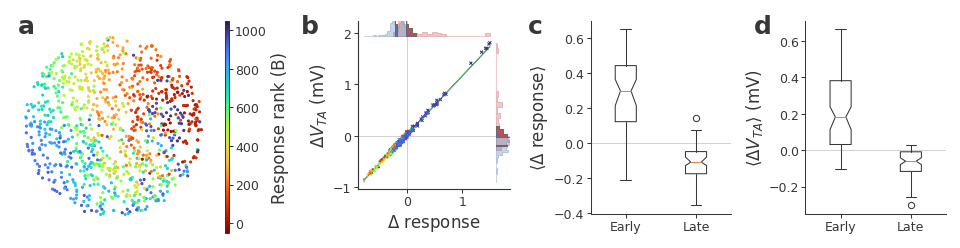

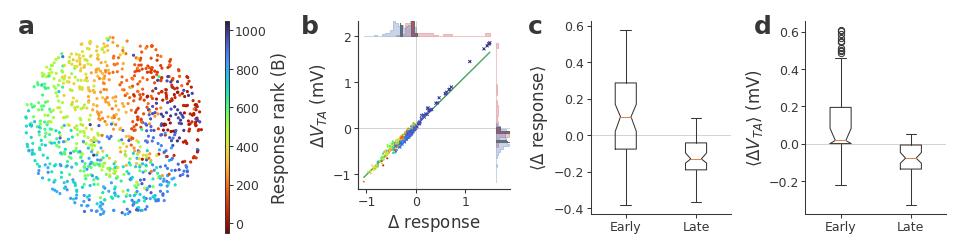

In [23]:
def make_figure_6(data, STD):
    fig = plt.figure(figsize=(6.29, 1.5), dpi=150, layout='compressed')
    gs = fig.add_gridspec(1, 3, width_ratios=pu.fill_ratios(8, 6, 12))

    subfig_left = fig.add_subfigure(gs[0])
    panel_RB_latency(*subfig_left.subplots(1, 2, width_ratios=(50,1)), data)

    subfig_center = fig.add_subfigure(gs[1])
    panel_early_sample(subfig_center.add_subplot(), data)

    subfig_right = fig.add_subfigure(gs[2])
    gs_right = subfig_right.add_gridspec(1,2)
    panel_early_stats([subfig_right.add_subplot(gs_right[i]) for i in (0,1)], STD, vert=True)

    for ax in fig.axes:
        ax.patch.set_facecolor('none')
    
    for x, a in zip((.01, .31, .55, .79), 'abcd'):
        fig.text(x, 1, a, **styling.label_kwargs, va='top', ha='left')

print('No STD:')
make_figure_6(half, 0)
plt.savefig('paper-1/fig6.pdf')

print('\nWith STD:')
make_figure_6(joint, 1)
plt.savefig('paper-1/fig6-withSTD.pdf')

# Compare

In [77]:
diff = {
    'TA_A': [getattr(joint, k) - getattr(half, k) for k in ('TA_A_dev', 'TA_A_msc', 'dTA_A')],
    'XnotA': [getattr(joint, k) - getattr(half, k) for k in ('XB_dev', 'XnotA_msc', 'dXnotA')],
    'XA': [getattr(joint, k) - getattr(half, k) for k in ('XA_dev', 'XA_msc', 'dXA')]
}

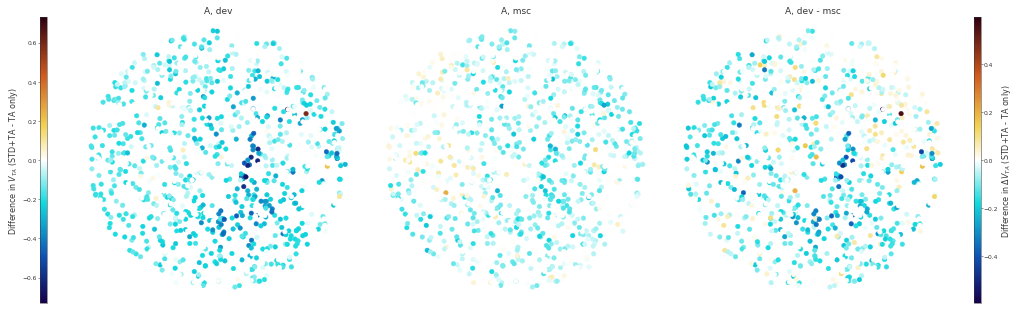

In [78]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4.2), constrained_layout=True)

vmax = np.abs(diff['TA_A'][:2]).max()
m = scatter_values(axs[0], c=diff['TA_A'][0], s=ms, vmin=-vmax, vmax=vmax, cmap=pu.ccc_divergent)
axs[0].set_title('A, dev')
m = scatter_values(axs[1], c=diff['TA_A'][1], s=ms, vmin=-vmax, vmax=vmax, cmap=pu.ccc_divergent)
axs[1].set_title('A, msc')
plt.colorbar(m, ax=axs, label='Difference in $V_{TA}$ (STD+TA - TA only)', location='left', aspect=40, pad=0.02)

vmax = np.abs(diff['TA_A'][2]).max()
m = scatter_values(axs[2], c=diff['TA_A'][2], s=ms, vmin=-vmax, vmax=vmax, cmap=pu.ccc_divergent)
axs[2].set_title('A, dev - msc')
plt.colorbar(m, ax=axs, label='Difference in $\\Delta V_{TA}$ (STD+TA - TA only)', aspect=40, pad=0.02)

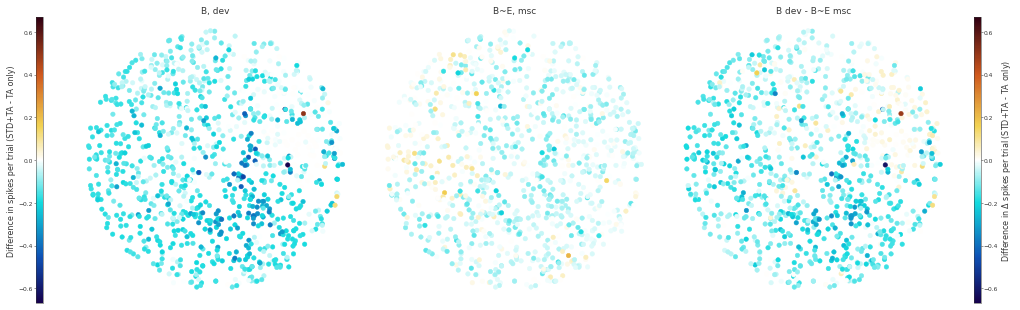

In [79]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4.2), constrained_layout=True)

vmax = np.abs(diff['XnotA']).max()
m = scatter_values(axs[0], c=diff['XnotA'][0], s=ms, vmin=-vmax, vmax=vmax, cmap=pu.ccc_divergent)
axs[0].set_title('B, dev')
m = scatter_values(axs[1], c=diff['XnotA'][1], s=ms, vmin=-vmax, vmax=vmax, cmap=pu.ccc_divergent)
axs[1].set_title('B~E, msc')
plt.colorbar(m, ax=axs, label='Difference in spikes per trial (STD+TA - TA only)', location='left', aspect=40, pad=0.02)

vmax = np.abs(diff['XnotA']).max()
m = scatter_values(axs[2], c=diff['XnotA'][2], s=ms, vmin=-vmax, vmax=vmax, cmap=pu.ccc_divergent)
axs[2].set_title('B dev - B~E msc')
plt.colorbar(m, ax=axs, label='Difference in $\\Delta$ spikes per trial (STD+TA - TA only)', aspect=40, pad=0.02)

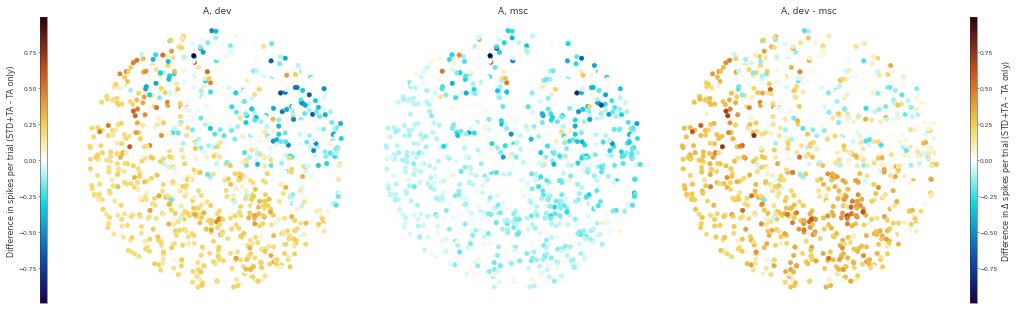

In [80]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4.2), constrained_layout=True)

vmax = np.abs(diff['XA']).max()
m = scatter_values(axs[0], c=diff['XA'][0], s=ms, vmin=-vmax, vmax=vmax, cmap=pu.ccc_divergent)
axs[0].set_title('A, dev')
m = scatter_values(axs[1], c=diff['XA'][1], s=ms, vmin=-vmax, vmax=vmax, cmap=pu.ccc_divergent)
axs[1].set_title('A, msc')
plt.colorbar(m, ax=axs, label='Difference in spikes per trial (STD+TA - TA only)', location='left', aspect=40, pad=0.02)

vmax = np.abs(diff['XA']).max()
m = scatter_values(axs[2], c=diff['XA'][2], s=ms, vmin=-vmax, vmax=vmax, cmap=pu.ccc_divergent)
axs[2].set_title('A, dev - msc')
plt.colorbar(m, ax=axs, label='Difference in $\\Delta$ spikes per trial (STD+TA - TA only)', aspect=40, pad=0.02)

In [81]:
nspikes = dd.io.load('Fig5n-stats.h5')
TAdata = dd.io.load('Fig8-synergy.h5', '/TA')
Ddata = dd.io.load('Fig8-synergy.h5', '/D')

ddResponse target > 0: t = 2.99, p = 0.00168
ddResponse non-target < 0: t = -3.19, p = 0.000921


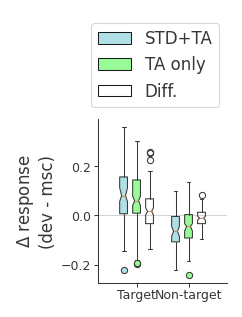

In [94]:
color_half, color_full = 'palegreen', 'powderblue'
pos = np.arange(2)
stats_pos = (pos, pos+.25, pos+.5)
stats_width = .15
def panel_stats_spikes(ax, nspikes, dXnotA):
    dX = [(nspikes[STD][1]['dev'] - nspikes[STD][1]['msc'])/cfg.params['N'] for STD in (1, 0)]
    dX.append(dX[0] - dX[1])

    dX_notA = [dXnotA[STD].mean(1) for STD in (1, 0)]
    dX_notA.append(dX_notA[0] - dX_notA[1])

    dFull, dHalf, dDiff = zip(dX, dX_notA)

    ax.boxplot(dFull, positions=stats_pos[0], notch=True, bootstrap=10000, patch_artist=True, widths=stats_width,
        boxprops={'facecolor': color_full}, flierprops={'markerfacecolor': color_full})

    ax.boxplot(dHalf, positions=stats_pos[1], notch=True, bootstrap=10000, patch_artist=True, widths=stats_width,
        boxprops={'facecolor': color_half}, flierprops={'markerfacecolor': color_half})
    
    ax.boxplot(dDiff, positions=stats_pos[2], notch=True, bootstrap=10000, widths=stats_width)
    ax.axhline(0, color='lightgrey', zorder=0)

    test = stats.ttest_1samp(dX[-1], 0, alternative='greater')
    print(f'ddResponse target > 0: t = {test.statistic:.3g}, p = {test.pvalue:.3g}')
    test = stats.ttest_1samp(dX_notA[-1], 0, alternative='less')
    print(f'ddResponse non-target < 0: t = {test.statistic:.3g}, p = {test.pvalue:.3g}')

    ax.set_xticks(np.mean(stats_pos, 0), ['Target', 'Non-target'])
    ax.set_ylabel('$\\Delta$ response\n(dev - msc)')
    sns.despine(ax=ax)

def legend_stats(ax, diff='Diff.', **kwargs):
    ax.fill_between([], [], [], label='STD+TA', color=color_full, ec='k')
    ax.fill_between([], [], [], label='TA only', color=color_half, ec='k')
    ax.fill_between([], [], [], label=diff, color='w', ec='k')
    ax.legend(**kwargs)
    sns.despine(ax=ax, left=True, bottom=True)
    ax.set_xticks([])
    ax.set_yticks([])

fig = plt.figure(figsize=(1.5,2), layout='constrained', dpi=150)
gs = fig.add_gridspec(2,1, height_ratios=(1,5))
legend_stats(fig.add_subplot(gs[0]))
panel_stats_spikes(fig.add_subplot(gs[1]), nspikes, statistics['dXnotA'])

ddV_TA < 0: t = -3.49, p = 0.000342


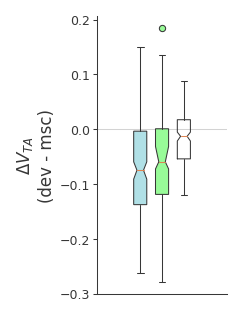

In [95]:
def panel_stats_TA(ax, dTA_A):
    dTA = [dTA_A[STD].mean(1) for STD in (1, 0)]
    dTA.append(dTA[0] - dTA[1])

    ax.boxplot([dTA[0]], positions=[stats_pos[0][0]], notch=True, bootstrap=10000, patch_artist=True, widths=stats_width,
        boxprops={'facecolor': color_full}, flierprops={'markerfacecolor': color_full})

    ax.boxplot([dTA[1]], positions=[stats_pos[1][0]], notch=True, bootstrap=10000, patch_artist=True, widths=stats_width,
        boxprops={'facecolor': color_half}, flierprops={'markerfacecolor': color_half})
    
    ax.boxplot([dTA[2]], positions=[stats_pos[2][0]], notch=True, bootstrap=10000, widths=stats_width)
    ax.axhline(0, color='lightgrey', zorder=0)

    test = stats.ttest_1samp(dTA[-1], 0, alternative='less')
    print(f'ddV_TA < 0: t = {test.statistic:.3g}, p = {test.pvalue:.3g}')

    ax.set_xticks([])
    ax.set_ylabel('$\\Delta V_{TA}$\n(dev - msc)')
    sns.despine(ax=ax)

fig, ax = plt.subplots(figsize=(1.5,2), layout='constrained', dpi=150)
panel_stats_TA(ax, statistics['dTA_A'])

ddResponse target > 0: t = 2.99, p = 0.00168
ddResponse non-target < 0: t = -3.19, p = 0.000921
ddV_TA < 0: t = -3.49, p = 0.000342


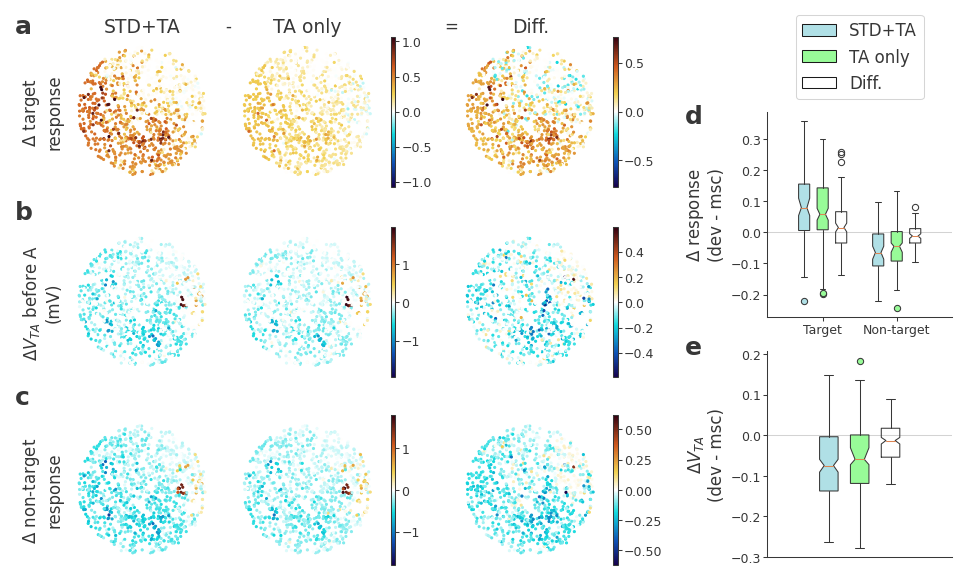

In [96]:
fig = plt.figure(figsize=(6.29, 3.75), dpi=150, layout='compressed')
gs_top = fig.add_gridspec(1, 2, width_ratios=(7,3))

subfig_left = fig.add_subfigure(gs_top[0])
wr = pu.fill_ratios(-1, -1, 1, -1, 1)
gs_left = subfig_left.add_gridspec(3, 5, width_ratios=wr, hspace=.2)

for row, (*data, title) in enumerate(((joint.dXA, half.TA_A_dev, diff['XA'][2], '$\\Delta$ target\nresponse'),
                                      (joint.dTA_A, half.TA_A_msc, diff['TA_A'][2], '$\\Delta V_{TA}$ before A\n(mV)'),
                                      (joint.dXnotA, half.TA_A_dev, diff['XnotA'][2], '$\\Delta$ non-target\nresponse'))):
    cax_raw = subfig_left.add_subplot(gs_left[row, 2])
    axs_raw = [subfig_left.add_subplot(gs_left[row, i]) for i in range(2)]
    ax_diff = subfig_left.add_subplot(gs_left[row, 3])
    cax_diff = subfig_left.add_subplot(gs_left[row, 4])
    spatial_contrast(axs_raw, cax_raw, ax_diff, cax_diff, *data, raw_symmetric=True)
    if row == 0:
        axs_raw[0].set_title('STD+TA')
        axs_raw[1].set_title('TA only')
        ax_diff.set_title('Diff.')
        axs_raw[1].set_ylabel('-', rotation=0, y=1.04)
        ax_diff.set_ylabel('=', rotation=0, y=1.04)
    axs_raw[0].set_ylabel(title)

subfig_right = fig.add_subfigure(gs_top[1])
gs_summaries = subfig_right.add_gridspec(3, 1, height_ratios=(1,5,5))

legend_stats(subfig_right.add_subplot(gs_summaries[0]), loc='center')
panel_stats_spikes(subfig_right.add_subplot(gs_summaries[1]), nspikes, statistics['dXnotA'])
panel_stats_TA(subfig_right.add_subplot(gs_summaries[2]), statistics['dTA_A'])

for y, a in zip((.99, .66, .33), 'abc'):
    fig.text(0, y, a, **styling.label_kwargs, ha='left', va='top')
for y, a in zip((.83, .42), 'de'):
    fig.text(.71, y, a, **styling.label_kwargs, ha='left', va='top')

plt.savefig('paper-1/fig7.pdf')